In [1]:
import numpy as np
import keras
from keras import layers
from scipy.io import mmread
import tensorflow as tf
import pandas as pd
import time
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import os

import pickle
from datetime import datetime
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt 

pgf = False
if (pgf):
    matplotlib.use("pgf")
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })

2025-07-30 14:35:38.182485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753878938.195030  922766 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753878938.198654  922766 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-30 14:35:38.210703: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Fix random
seed = 42
reproductibility_mode = True

np.random.seed(seed)
keras.utils.set_random_seed(seed)
tf.random.set_seed(seed)

if(reproductibility_mode):
    tf.config.experimental.enable_op_determinism()

In [3]:
#log folder
log_dir = "logs/date_fruit/" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")


os.makedirs(log_dir, exist_ok=True)
os.makedirs("figures", exist_ok=True)

print("Logs save in :", log_dir)

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


Logs save in : logs/date_fruit/2025-07-30_14-35-40


In [ ]:
NUM_CLASSES = 7
CLASS_COL = "Class"
dataset_path = "../../data/date_fruit_datasets.csv"

ds_import = pd.read_csv(dataset_path, sep=";", header=0, index_col=False)

In [5]:
total_column_count = len(ds_import.columns)
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_y_train = ds_import[CLASS_COL]
df_x_train = ds_import.drop([CLASS_COL], axis=1)
y = keras.utils.to_categorical(np.asarray(df_y_train.factorize()[0]))

In [6]:
#SPLIT DATASET

x_train, x_test, y_train, y_test = train_test_split(df_x_train, y, test_size=0.2, random_state=seed)
scaler = StandardScaler()
scaler.fit(x_train)
scaler.mean_
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
scaled_data_df = pd.DataFrame(x_train, columns=df_x_train.columns)


In [7]:
#HYPERPARAMETERS

hidden_units = [512, 512, 512, 512, 256]
hidden_units_med = [256, 256, 256, 256, 128]
hidden_units_low = [64, 64, 64, 64, 32]

hidden_units_verylow = [32, 32, 32, 32, 16]
dropout = [0.25, 0.25, 0.25, 0.25, 0]
CLASSIFIER_ACTIVATION = 'softmax'
epoch = 30
batch_size=128

In [8]:
base_time_train = []

model = keras.Sequential([
        keras.layers.Dense(hidden_units[0], input_shape=(df_x_train.shape[1],), activation='relu'),
        keras.layers.Dropout(dropout[0]),
        keras.layers.Dense(hidden_units[1], activation='relu'),
        keras.layers.Dropout(dropout[1]),
        keras.layers.Dense(hidden_units[2], activation='relu'),
        keras.layers.Dropout(dropout[2]),
        keras.layers.Dense(hidden_units[3], activation='relu'),
        keras.layers.Dropout(dropout[3]),
        keras.layers.Dense(hidden_units[4], activation='relu'),
        keras.layers.Dropout(dropout[4]),
        keras.layers.Dense(NUM_CLASSES, activation=CLASSIFIER_ACTIVATION)
    ])
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
start_time = time.time()
history = model.fit(x_train, y_train,epochs=epoch, batch_size=batch_size, verbose=0)
base_time_train.append(time.time() - start_time)
print("---- %s seconds ----" % (time.time() - start_time))
start_time = time.time()
acc = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
print("---- %s seconds ----" % (time.time() - start_time))

print("Test loss:", acc[0])
print("Test accuracy:", acc[1])

model.save(os.path.join(log_dir, "model_large.keras"))
model_large_acc = acc[1]

/home/qpetit/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1753878940.590067  922766 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4077 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 939,015 (3.58 MB)

 Trainable params: 939,015 (3.58 MB)

 Non-trainable params: 0 (0.00 B)

2025-07-30 14:35:41.243607: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
I0000 00:00:1753878942.409060  922817 service.cc:148] XLA service 0x77a5d000e600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753878942.409079  922817 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capabilit

---- 5.425957679748535 seconds ----


2025-07-30 14:35:46.661085: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- 0.6522915363311768 seconds ----
Test loss: 0.19788716733455658
Test accuracy: 0.9277777671813965


In [9]:

model = keras.Sequential([
        keras.layers.Dense(hidden_units_med[0], input_shape=(df_x_train.shape[1],), activation='relu'),
        keras.layers.Dropout(dropout[0]),
        keras.layers.Dense(hidden_units_med[1], activation='relu'),
        keras.layers.Dropout(dropout[1]),
        keras.layers.Dense(hidden_units_med[2], activation='relu'),
        keras.layers.Dropout(dropout[2]),
        keras.layers.Dense(hidden_units_med[3], activation='relu'),
        keras.layers.Dropout(dropout[3]),
        keras.layers.Dense(hidden_units_med[4], activation='relu'),
        keras.layers.Dropout(dropout[4]),
        keras.layers.Dense(NUM_CLASSES, activation=CLASSIFIER_ACTIVATION)
    ])
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
start_time = time.time()
history = model.fit(x_train, y_train,epochs=epoch, batch_size=batch_size, verbose=0)
base_time_train.append(time.time() - start_time)
print("---- %s seconds ----" % (time.time() - start_time))
start_time = time.time()
acc = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
print("---- %s seconds ----" % (time.time() - start_time))

print("Test loss:", acc[0])
print("Test accuracy:", acc[1])

model.save(os.path.join(log_dir, "model_med.keras"))
model_med_acc = acc[1]

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 256)            │         8,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,135 (938.03 KB)

 Trainable params: 240,135 (938.03 KB)

 Non-trainable params: 0 (0.00 B)

---- 5.148169994354248 seconds ----


2025-07-30 14:35:52.588827: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- 0.6416294574737549 seconds ----
Test loss: 0.21978986263275146
Test accuracy: 0.9277777671813965


In [10]:

model = keras.Sequential([
        keras.layers.Dense(hidden_units_low[0], input_shape=(df_x_train.shape[1],), activation='relu'),
        keras.layers.Dropout(dropout[0]),
        keras.layers.Dense(hidden_units_low[1], activation='relu'),
        keras.layers.Dropout(dropout[1]),
        keras.layers.Dense(hidden_units_low[2], activation='relu'),
        keras.layers.Dropout(dropout[2]),
        keras.layers.Dense(hidden_units_low[3], activation='relu'),
        keras.layers.Dropout(dropout[3]),
        keras.layers.Dense(hidden_units_low[4], activation='relu'),
        keras.layers.Dropout(dropout[4]),
        keras.layers.Dense(NUM_CLASSES, activation=CLASSIFIER_ACTIVATION)
    ])
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
start_time = time.time()
history = model.fit(x_train, y_train,epochs=epoch, batch_size=batch_size, verbose=0)
base_time_train.append(time.time() - start_time)
print("---- %s seconds ----" % (time.time() - start_time))
start_time = time.time()
acc = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
print("---- %s seconds ----" % (time.time() - start_time))

print("Test loss:", acc[0])
print("Test accuracy:", acc[1])

model.save(os.path.join(log_dir, "model_low.keras"))
model_low_acc = acc[1]

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │         2,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,031 (66.53 KB)

 Trainable params: 17,031 (66.53 KB)

 Non-trainable params: 0 (0.00 B)

---- 5.102351188659668 seconds ----


2025-07-30 14:35:58.440439: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- 0.6745266914367676 seconds ----
Test loss: 0.3236999809741974
Test accuracy: 0.8777777552604675


In [11]:

model = keras.Sequential([
        keras.layers.Dense(hidden_units_verylow[0], input_shape=(df_x_train.shape[1],), activation='relu'),
        keras.layers.Dropout(dropout[0]),
        keras.layers.Dense(hidden_units_verylow[1], activation='relu'),
        keras.layers.Dropout(dropout[1]),
        keras.layers.Dense(hidden_units_verylow[2], activation='relu'),
        keras.layers.Dropout(dropout[2]),
        keras.layers.Dense(hidden_units_verylow[3], activation='relu'),
        keras.layers.Dropout(dropout[3]),
        keras.layers.Dense(hidden_units_verylow[4], activation='relu'),
        keras.layers.Dropout(dropout[4]),
        keras.layers.Dense(NUM_CLASSES, activation=CLASSIFIER_ACTIVATION)
    ])
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
start_time = time.time()
history = model.fit(x_train, y_train,epochs=epoch, batch_size=batch_size, verbose=0)
base_time_train.append(time.time() - start_time)
print("---- %s seconds ----" % (time.time() - start_time))
start_time = time.time()
acc = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
print("---- %s seconds ----" % (time.time() - start_time))

print("Test loss:", acc[0])
print("Test accuracy:", acc[1])

model.save(os.path.join(log_dir, "model_verylow.keras"))
model_verylow_acc = acc[1]

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 32)             │         1,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,935 (19.28 KB)

 Trainable params: 4,935 (19.28 KB)

 Non-trainable params: 0 (0.00 B)

---- 5.105140924453735 seconds ----


2025-07-30 14:36:04.323653: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- 0.6477093696594238 seconds ----
Test loss: 0.5531842708587646
Test accuracy: 0.7722222208976746


In [12]:
MAX_EV_EXPLORE = 17

In [13]:
def readMTX(input_path):
    is_init = False
    count = 0
    expected = 0
    with open(input_path, "r") as file:
        lines = file.readlines()
        for line in lines:
            list_line = line.split()
            if list_line[0].isdigit():
                if(not is_init):
                    is_init = True
                    ev = np.zeros((int(list_line[0]), int(list_line[1])))
                    expected = int(list_line[2])
                else:
                    ev[int(list_line[0]) - 1][int(list_line[1]) - 1] = float(list_line[2])
                    count = count + 1
                
    if(expected != count):
        print("Err: Not the same nnz between expected and find ", str(count), "/", str(expected))
    return ev


In [ ]:
acc_test_large = []
acc_test_med = []
acc_test_low = []
acc_test_verylow = []
emb_time_train = []


for i in range(MAX_EV_EXPLORE):
    path_ev = "../../data/output/date_fruit/eigen_" + str(i + 1) + ".mtx"
    ev = readMTX(path_ev)
    print(ev.shape)
    x_train_emb = np.matmul(x_train,ev)
    x_test_emb = np.matmul(x_test,ev)
    model_emb = keras.Sequential([
            keras.layers.Dense(hidden_units[0], input_shape=(x_train_emb.shape[1],), activation='relu'),
            keras.layers.Dropout(dropout[0]),
            keras.layers.Dense(hidden_units[1], activation='relu'),
            keras.layers.Dropout(dropout[1]),
            keras.layers.Dense(hidden_units[2], activation='relu'),
            keras.layers.Dropout(dropout[2]),
            keras.layers.Dense(hidden_units[3], activation='relu'),
            keras.layers.Dropout(dropout[3]),
            keras.layers.Dense(hidden_units[4], activation='relu'),
            keras.layers.Dropout(dropout[4]),
            keras.layers.Dense(NUM_CLASSES, activation=CLASSIFIER_ACTIVATION)
        ])
    model_emb.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    start_time = time.time()
    history = model_emb.fit(x_train_emb, y_train,epochs=epoch, batch_size=batch_size, verbose=0)
    emb_time_train.append(time.time() - start_time)
    print("---- Train large : %s seconds ----" % (time.time() - start_time))
    start_time = time.time()
    acc_emb = model_emb.evaluate(x_test_emb, y_test, batch_size=batch_size, verbose=0)
    print("---- Evaluate large : %s seconds ----" % (time.time() - start_time))
    acc_test_large.append(acc_emb[1])
    model_emb.save(os.path.join(log_dir, "emb_" + str(i) + "_model_large.keras"))
    
    model_emb = keras.Sequential([
            keras.layers.Dense(hidden_units_med[0], input_shape=(x_train_emb.shape[1],), activation='relu'),
            keras.layers.Dropout(dropout[0]),
            keras.layers.Dense(hidden_units_med[1], activation='relu'),
            keras.layers.Dropout(dropout[1]),
            keras.layers.Dense(hidden_units_med[2], activation='relu'),
            keras.layers.Dropout(dropout[2]),
            keras.layers.Dense(hidden_units_med[3], activation='relu'),
            keras.layers.Dropout(dropout[3]),
            keras.layers.Dense(hidden_units_med[4], activation='relu'),
            keras.layers.Dropout(dropout[4]),
            keras.layers.Dense(NUM_CLASSES, activation=CLASSIFIER_ACTIVATION)
        ])
    model_emb.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    start_time = time.time()
    history = model_emb.fit(x_train_emb, y_train,epochs=epoch, batch_size=batch_size, verbose=0)
    emb_time_train.append(time.time() - start_time)
    print("---- Train med : %s seconds ----" % (time.time() - start_time))
    start_time = time.time()
    acc_emb = model_emb.evaluate(x_test_emb, y_test, batch_size=batch_size, verbose=0)
    print("---- Evaluate med : %s seconds ----" % (time.time() - start_time))
        
    acc_test_med.append(acc_emb[1])
    model_emb.save(os.path.join(log_dir, "emb_" + str(i) + "_model_med.keras"))


    
    model_emb = keras.Sequential([
            keras.layers.Dense(hidden_units_low[0], input_shape=(x_train_emb.shape[1],), activation='relu'),
            keras.layers.Dropout(dropout[0]),
            keras.layers.Dense(hidden_units_low[1], activation='relu'),
            keras.layers.Dropout(dropout[1]),
            keras.layers.Dense(hidden_units_low[2], activation='relu'),
            keras.layers.Dropout(dropout[2]),
            keras.layers.Dense(hidden_units_low[3], activation='relu'),
            keras.layers.Dropout(dropout[3]),
            keras.layers.Dense(hidden_units_low[4], activation='relu'),
            keras.layers.Dropout(dropout[4]),
            keras.layers.Dense(NUM_CLASSES, activation=CLASSIFIER_ACTIVATION)
        ])
    model_emb.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    start_time = time.time()
    history = model_emb.fit(x_train_emb, y_train,epochs=epoch, batch_size=batch_size, verbose=0)
    emb_time_train.append(time.time() - start_time)
    print("---- Train low : %s seconds ----" % (time.time() - start_time))
    start_time = time.time()
    acc_emb = model_emb.evaluate(x_test_emb, y_test, batch_size=batch_size, verbose=0)
    print("---- Evaluate low : %s seconds ----" % (time.time() - start_time))
        
    acc_test_low.append(acc_emb[1])
    model_emb.save(os.path.join(log_dir, "emb_" + str(i) + "_model_low.keras"))

    model_emb = keras.Sequential([
            keras.layers.Dense(hidden_units_verylow[0], input_shape=(x_train_emb.shape[1],), activation='relu'),
            keras.layers.Dropout(dropout[0]),
            keras.layers.Dense(hidden_units_verylow[1], activation='relu'),
            keras.layers.Dropout(dropout[1]),
            keras.layers.Dense(hidden_units_verylow[2], activation='relu'),
            keras.layers.Dropout(dropout[2]),
            keras.layers.Dense(hidden_units_verylow[3], activation='relu'),
            keras.layers.Dropout(dropout[3]),
            keras.layers.Dense(hidden_units_verylow[4], activation='relu'),
            keras.layers.Dropout(dropout[4]),
            keras.layers.Dense(NUM_CLASSES, activation=CLASSIFIER_ACTIVATION)
        ])
    model_emb.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    start_time = time.time()
    history = model_emb.fit(x_train_emb, y_train,epochs=epoch, batch_size=batch_size, verbose=0)
    emb_time_train.append(time.time() - start_time)
    print("---- Train very low : %s seconds ----" % (time.time() - start_time))
    start_time = time.time()
    acc_emb = model_emb.evaluate(x_test_emb, y_test, batch_size=batch_size, verbose=0)
    print("---- Evaluate very low : %s seconds ----" % (time.time() - start_time))
        
    acc_test_verylow.append(acc_emb[1])
    model_emb.save(os.path.join(log_dir, "emb_" + str(i) + "_model_verylow.keras"))

(34, 1)
---- Train large : 4.921792984008789 seconds ----


2025-07-30 14:36:10.161192: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate large : 0.5632565021514893 seconds ----
---- Train med : 4.8111021518707275 seconds ----


2025-07-30 14:36:15.625568: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate med : 0.548593282699585 seconds ----
---- Train low : 4.5869526863098145 seconds ----


2025-07-30 14:36:20.835977: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate low : 0.5365705490112305 seconds ----
---- Train very low : 4.622414588928223 seconds ----


2025-07-30 14:36:26.066766: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate very low : 0.5391561985015869 seconds ----
(34, 2)
---- Train large : 5.012531518936157 seconds ----


2025-07-30 14:36:31.692790: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate large : 0.4739720821380615 seconds ----
---- Train med : 4.77312159538269 seconds ----


2025-07-30 14:36:37.027400: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate med : 0.4708869457244873 seconds ----
---- Train low : 4.650241136550903 seconds ----


2025-07-30 14:36:42.220702: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate low : 0.46692323684692383 seconds ----
---- Train very low : 4.639323711395264 seconds ----


2025-07-30 14:36:47.396402: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate very low : 0.4663994312286377 seconds ----
(34, 3)
---- Train large : 4.791048526763916 seconds ----


2025-07-30 14:36:52.722132: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate large : 0.4640634059906006 seconds ----
---- Train med : 4.757251501083374 seconds ----


2025-07-30 14:36:58.031522: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate med : 0.4724299907684326 seconds ----
---- Train low : 4.8874242305755615 seconds ----


2025-07-30 14:37:03.465426: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate low : 0.4692699909210205 seconds ----
---- Train very low : 4.632398843765259 seconds ----


2025-07-30 14:37:08.638458: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate very low : 0.4725501537322998 seconds ----
(34, 4)
---- Train large : 4.88823390007019 seconds ----


2025-07-30 14:37:14.076447: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate large : 0.47536659240722656 seconds ----
---- Train med : 4.796755075454712 seconds ----


2025-07-30 14:37:19.433969: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate med : 0.4699127674102783 seconds ----
---- Train low : 4.682791471481323 seconds ----


2025-07-30 14:37:24.661450: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate low : 0.4712514877319336 seconds ----
---- Train very low : 4.640377998352051 seconds ----


2025-07-30 14:37:29.840940: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate very low : 0.49475955963134766 seconds ----
(34, 5)
---- Train large : 4.7896482944488525 seconds ----


2025-07-30 14:37:35.213121: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate large : 0.47221875190734863 seconds ----
---- Train med : 5.1349732875823975 seconds ----


2025-07-30 14:37:40.909316: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate med : 0.474625825881958 seconds ----
---- Train low : 4.6680097579956055 seconds ----


2025-07-30 14:37:46.127588: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate low : 0.46973729133605957 seconds ----
---- Train very low : 4.64709210395813 seconds ----


2025-07-30 14:37:51.316798: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate very low : 0.47642040252685547 seconds ----
(34, 6)
---- Train large : 4.860504865646362 seconds ----


2025-07-30 14:37:56.723389: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate large : 0.47289013862609863 seconds ----
---- Train med : 4.805662393569946 seconds ----


2025-07-30 14:38:02.087541: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate med : 0.4687051773071289 seconds ----
---- Train low : 4.667511463165283 seconds ----


2025-07-30 14:38:07.297920: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate low : 0.4673948287963867 seconds ----
---- Train very low : 4.640429496765137 seconds ----


2025-07-30 14:38:12.481434: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate very low : 0.4820117950439453 seconds ----
(34, 7)
---- Train large : 4.835710287094116 seconds ----


2025-07-30 14:38:17.875046: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate large : 0.48192739486694336 seconds ----
---- Train med : 5.218873739242554 seconds ----


2025-07-30 14:38:23.661700: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate med : 0.47896599769592285 seconds ----
---- Train low : 4.711876630783081 seconds ----


2025-07-30 14:38:28.931189: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate low : 0.47955799102783203 seconds ----
---- Train very low : 4.675914764404297 seconds ----


2025-07-30 14:38:34.156329: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate very low : 0.4756739139556885 seconds ----
(34, 8)
---- Train large : 4.880479574203491 seconds ----


2025-07-30 14:38:39.595589: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate large : 0.48668527603149414 seconds ----
---- Train med : 4.746665000915527 seconds ----


2025-07-30 14:38:44.907102: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate med : 0.48365235328674316 seconds ----
---- Train low : 4.654143571853638 seconds ----


2025-07-30 14:38:50.120252: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate low : 0.4873678684234619 seconds ----
---- Train very low : 4.665809392929077 seconds ----


2025-07-30 14:38:55.344598: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate very low : 0.4832897186279297 seconds ----
(34, 9)
---- Train large : 4.827486276626587 seconds ----


2025-07-30 14:39:00.732522: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate large : 0.4786040782928467 seconds ----
---- Train med : 4.748934030532837 seconds ----


2025-07-30 14:39:06.048449: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate med : 0.4730050563812256 seconds ----
---- Train low : 4.662448167800903 seconds ----


2025-07-30 14:39:11.256194: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate low : 0.4752161502838135 seconds ----
---- Train very low : 5.240700006484985 seconds ----


2025-07-30 14:39:17.040992: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate very low : 0.49704527854919434 seconds ----
(34, 10)
---- Train large : 4.8993446826934814 seconds ----


2025-07-30 14:39:22.522073: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate large : 0.4874231815338135 seconds ----
---- Train med : 4.770871162414551 seconds ----


2025-07-30 14:39:27.873450: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate med : 0.49318909645080566 seconds ----
---- Train low : 4.6475510597229 seconds ----


2025-07-30 14:39:33.101147: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate low : 0.48146700859069824 seconds ----
---- Train very low : 4.669651746749878 seconds ----


2025-07-30 14:39:38.321055: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate very low : 0.4749455451965332 seconds ----
(34, 11)
---- Train large : 4.859119892120361 seconds ----


2025-07-30 14:39:43.736833: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate large : 0.4806220531463623 seconds ----
---- Train med : 4.757451057434082 seconds ----


2025-07-30 14:39:49.061767: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate med : 0.48160529136657715 seconds ----
---- Train low : 4.6706156730651855 seconds ----


2025-07-30 14:39:54.289293: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate low : 0.47603654861450195 seconds ----
---- Train very low : 4.665872097015381 seconds ----


2025-07-30 14:39:59.501086: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate very low : 0.47859692573547363 seconds ----
(34, 12)
---- Train large : 4.8577611446380615 seconds ----


2025-07-30 14:40:04.911568: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate large : 0.48238468170166016 seconds ----
---- Train med : 4.784469842910767 seconds ----


2025-07-30 14:40:10.266839: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate med : 0.47493505477905273 seconds ----
---- Train low : 7.552214860916138 seconds ----


2025-07-30 14:40:18.369904: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate low : 0.487382173538208 seconds ----
---- Train very low : 4.695797681808472 seconds ----


2025-07-30 14:40:23.623120: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate very low : 0.4805178642272949 seconds ----
(34, 13)
---- Train large : 4.906682014465332 seconds ----


2025-07-30 14:40:29.087116: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate large : 0.48184847831726074 seconds ----
---- Train med : 4.778101682662964 seconds ----


2025-07-30 14:40:34.439469: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate med : 0.48122715950012207 seconds ----
---- Train low : 4.6887500286102295 seconds ----


2025-07-30 14:40:39.686910: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate low : 0.46691131591796875 seconds ----
---- Train very low : 4.730408191680908 seconds ----


2025-07-30 14:40:44.952737: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate very low : 0.47417593002319336 seconds ----
(34, 14)
---- Train large : 4.898891448974609 seconds ----


2025-07-30 14:40:50.401869: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate large : 0.4801218509674072 seconds ----
---- Train med : 4.7719128131866455 seconds ----


2025-07-30 14:40:55.740973: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate med : 0.4932594299316406 seconds ----
---- Train low : 4.6632702350616455 seconds ----


2025-07-30 14:41:00.972373: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate low : 0.47603750228881836 seconds ----
---- Train very low : 4.654498338699341 seconds ----


2025-07-30 14:41:06.172319: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate very low : 0.48030877113342285 seconds ----
(34, 15)
---- Train large : 4.834329128265381 seconds ----


2025-07-30 14:41:11.557235: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate large : 0.47418951988220215 seconds ----
---- Train med : 4.782799005508423 seconds ----


2025-07-30 14:41:16.902018: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate med : 0.47815489768981934 seconds ----
---- Train low : 4.66974139213562 seconds ----


2025-07-30 14:41:22.124595: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate low : 0.48171210289001465 seconds ----
---- Train very low : 4.691802978515625 seconds ----


2025-07-30 14:41:27.366528: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate very low : 0.47760558128356934 seconds ----
(34, 16)
---- Train large : 5.653839826583862 seconds ----


2025-07-30 14:41:33.575718: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate large : 0.48500800132751465 seconds ----
---- Train med : 4.858100175857544 seconds ----


2025-07-30 14:41:39.012015: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate med : 0.48265600204467773 seconds ----
---- Train low : 4.644352912902832 seconds ----


2025-07-30 14:41:44.218322: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate low : 0.4793868064880371 seconds ----
---- Train very low : 4.676212310791016 seconds ----


2025-07-30 14:41:49.443502: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate very low : 0.48230528831481934 seconds ----
(34, 17)
---- Train large : 4.8294196128845215 seconds ----


2025-07-30 14:41:54.821871: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate large : 0.48510074615478516 seconds ----
---- Train med : 4.749325752258301 seconds ----


2025-07-30 14:42:00.146445: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate med : 0.47810959815979004 seconds ----
---- Train low : 6.856117486953735 seconds ----


2025-07-30 14:42:07.554562: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate low : 0.5034663677215576 seconds ----
---- Train very low : 4.688167333602905 seconds ----


2025-07-30 14:42:12.820634: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate very low : 0.4781792163848877 seconds ----


In [15]:
print(acc_test_large)
print(acc_test_med)
print(acc_test_low)
print(acc_test_verylow)

[0.5555555820465088, 0.7388888597488403, 0.8833333253860474, 0.894444465637207, 0.9166666865348816, 0.9111111164093018, 0.8611111044883728, 0.8833333253860474, 0.9333333373069763, 0.9222221970558167, 0.9444444179534912, 0.9388889074325562, 0.9277777671813965, 0.9333333373069763, 0.9666666388511658, 0.9333333373069763, 0.9222221970558167]
[0.5666666626930237, 0.7666666507720947, 0.8888888955116272, 0.8777777552604675, 0.9055555462837219, 0.9111111164093018, 0.8999999761581421, 0.9055555462837219, 0.9166666865348816, 0.9388889074325562, 0.949999988079071, 0.9166666865348816, 0.9277777671813965, 0.9333333373069763, 0.9277777671813965, 0.9444444179534912, 0.9277777671813965]
[0.47777777910232544, 0.7666666507720947, 0.7944444417953491, 0.8611111044883728, 0.8333333134651184, 0.8222222328186035, 0.8388888835906982, 0.8611111044883728, 0.8777777552604675, 0.8777777552604675, 0.8999999761581421, 0.8833333253860474, 0.8722222447395325, 0.8833333253860474, 0.894444465637207, 0.894444465637207, 

In [16]:
index = []
ticks = []
model_base = []
model_med_base = []
model_low_base = []
model_verylow_base = []
time_base_large = []
time_base_med = []
time_base_low = []
time_base_verylow = []


for i in range(len(acc_test_large)-1):
    if(i %3 == 0):
        if(len(acc_test_large) - i < 3):
            index.append(" ")
        else:
            index.append(i + 1)
    else:
        index.append(" ")
    ticks.append(i)
ticks.append(len(acc_test_large)-1)
index.append(len(acc_test_large))
index.append(" ")
index.append("...")
index.append(" ")
index.append(df_x_train.shape[1])
for i in range(len(acc_test_large), len(acc_test_large) + 4):
    ticks.append(i)

for i in range(len(acc_test_large) + 4):
    model_base.append(model_large_acc)
    model_med_base.append(model_med_acc)
    model_low_base.append(model_low_acc)
    model_verylow_base.append(model_verylow_acc)
    time_base_large.append(base_time_train[0])
    time_base_med.append(base_time_train[1])
    time_base_low.append(base_time_train[2])
    time_base_verylow.append(base_time_train[3])

#Time preprocessing

time_large = []
time_med = []
time_low = []
time_verylow = []

for i in range(len(acc_test_large)):
    time_large.append(emb_time_train[4 * i])
    time_med.append(emb_time_train[4 * i + 1])
    time_low.append(emb_time_train[4 * i + 2])
    time_verylow.append(emb_time_train[4 * i + 3])



In [17]:
#Save results

with open(os.path.join(log_dir, "emb_acc.pkl"), "wb") as f:
    pickle.dump([acc_test_large, acc_test_med, acc_test_low, acc_test_verylow], f)

with open(os.path.join(log_dir, "base_acc.pkl"), "wb") as f:
    pickle.dump([model_large_acc, model_med_acc, model_low_acc, model_verylow_acc], f)

with open(os.path.join(log_dir, "train_time.pkl"), "wb") as f:
    pickle.dump([base_time_train, emb_time_train], f)

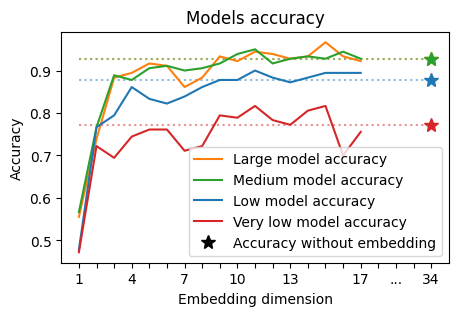

In [18]:
# summarize history for accuracy

plt.figure(figsize=(5,3))
plt.plot(model_base, color=('tab:orange', 0.5), ls=':')
plt.plot(model_med_base, color=('tab:green', 0.5), ls=':')
plt.plot(model_low_base, color=('tab:blue', 0.5), ls=':')
plt.plot(model_verylow_base, color=('tab:red',0.5), ls=':')

plt.plot(len(acc_test_large) + 3, model_large_acc, marker='*', color='tab:orange', markersize=10, linestyle='None', label='_nolegend_')
plt.plot(len(acc_test_med) + 3, model_med_acc, marker='*', color='tab:green', markersize=10, linestyle='None', label='_nolegend_')
plt.plot(len(acc_test_low) + 3, model_low_acc, marker='*', color='tab:blue', markersize=10, linestyle='None', label='_nolegend_')
plt.plot(len(acc_test_verylow) + 3, model_verylow_acc, marker='*', color='tab:red', markersize=10, linestyle='None', label='_nolegend_')

plt.plot(acc_test_large, label='Large model accuracy', color='tab:orange', ls='-')
plt.plot(acc_test_med, label='Medium model accuracy', color='tab:green', ls='-')
plt.plot(acc_test_low, label='Low model accuracy', color='tab:blue', ls='-')
plt.plot(acc_test_verylow, label='Very low model accuracy', color='tab:red', ls='-')

black_star_proxy = mlines.Line2D([], [], color='black', marker='*', linestyle='None',
                                 markersize=10, label='Accuracy without embedding')
plt.title('Models accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Embedding dimension')
plt.xticks(ticks, index)

handles, labels = plt.gca().get_legend_handles_labels()
handles.append(black_star_proxy)

plt.legend(handles=handles)
plt.savefig('figures/date_fruits_accuracy_full.pgf', bbox_inches='tight', dpi=4000)
plt.savefig('figures/date_fruits_accuracy_full.png', bbox_inches='tight', dpi=2000)

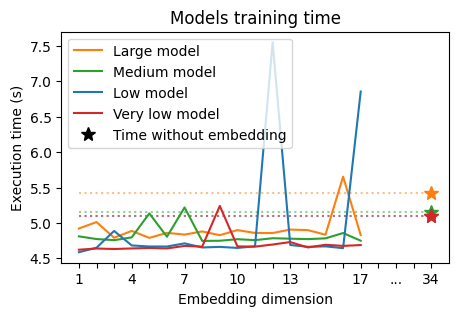

In [19]:
#Plot training time


plt.figure(figsize=(5,3))
plt.plot(time_base_large, color=('tab:orange', 0.5), ls=':')
plt.plot(time_base_med, color=('tab:green', 0.5), ls=':')
plt.plot(time_base_low, color=('tab:blue', 0.5), ls=':')
plt.plot(time_base_verylow, color=('tab:red',0.5), ls=':')

plt.plot(len(acc_test_large) + 3, base_time_train[0], marker='*', color='tab:orange', markersize=10, linestyle='None', label='_nolegend_')
plt.plot(len(acc_test_med) + 3, base_time_train[1], marker='*', color='tab:green', markersize=10, linestyle='None', label='_nolegend_')
plt.plot(len(acc_test_low) + 3, base_time_train[2], marker='*', color='tab:blue', markersize=10, linestyle='None', label='_nolegend_')
plt.plot(len(acc_test_verylow) + 3, base_time_train[3], marker='*', color='tab:red', markersize=10, linestyle='None', label='_nolegend_')

plt.plot(time_large, label='Large model', color='tab:orange', ls='-')
plt.plot(time_med, label='Medium model', color='tab:green', ls='-')
plt.plot(time_low, label='Low model', color='tab:blue', ls='-')
plt.plot(time_verylow, label='Very low model', color='tab:red', ls='-')

black_star_proxy = mlines.Line2D([], [], color='black', marker='*', linestyle='None',
                                 markersize=10, label='Time without embedding')

plt.title('Models training time')
plt.ylabel('Execution time (s)')
plt.xlabel('Embedding dimension')
plt.xticks(ticks, index)

handles, labels = plt.gca().get_legend_handles_labels()
handles.append(black_star_proxy)

plt.legend(handles=handles)
plt.savefig('figures/training_time_date_fruits_accuracy_full.pgf', bbox_inches='tight', dpi=4000)
plt.savefig('figures/training_time_date_fruits_accuracy_full.png', bbox_inches='tight', dpi=2000)
